<a href="https://colab.research.google.com/github/seisbench/seisbench/blob/additional_example_workflows/examples/01b_model_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [33]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [35]:
# Try importing obspy (used by SeisBench)
try:
    import obspy
    obspy.read()         # Try reading a dummy trace
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()            # Force runtime stop so Colab can restart and fix the issue and go back to Cell 1 and run the notebook again

# Model API

This tutorial introduces the SeisBench model API. It explains how to load pretrained models and apply them to generate characteristic curves or discrete picks.

**Note:** Some familiarity with obspy is helpful for this tutorial, but not required.

In [36]:
import seisbench  #  Load the main seisbench library
import seisbench.models as sbm  #Loads the module seisbench.models, which contains all the available ML models for picking or denoising

### Creating a model

SeisBench models are built in pytorch. They can simply be created by intiatiating an object of the desired class.
Let's first create a simple PhaseNet model. As we see in the output, the model consists of a down branch and an up branch, both comprised of (transposed) convolutional layers. Furthermore, the model indicates that it expects data with ZNE component order

In [37]:
# Load the PhaseNet model from seisbench (used for phase picking)
model = sbm.PhaseNet()
# Print the structure of the model, including all layers and settings
print(model)

Component order:	ZNE
SeisBench model		PhaseNet

PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      

As pytorch model, the model can be applied to pytorch tensors. The output for PhaseNet are probabilities for P arrivals, S arrivals and noise for every sample.

In [38]:
# Import the PyTorch library (used to handle tensors and run deep learning models)
import torch

# We gave the model a fake waveform (random data) with Shape: (1, 3, 3001)
# → 1 sample or example (just 1 waveform)
# → 3 channels (Z, N, E components)
# → 3001 time steps (e.g., 30 seconds at 100 Hz)
x = torch.rand(1, 3, 3001)  # 1 example, 3 components, 3001 samples

# Put the model in evaluation mode (very important for testing)
# This disables things like dropout and batch normalization updates
model.eval()

# Disable gradient calculation (since we are not training the model)
# This saves memory and speeds up the computation
with torch.no_grad():
    # Pass the dummy input through the model and print the output
    # Output shape will be: (1, 3, 3001)
    # → 1 = single trace
    # → 3 = probabilities for [P, S, Noise]
    # → 3001 =predictions for each time step
    print(model(x))

#The model givesthe probability (0 to 1) of P, S, or Noise at each moment in time
#Each number = probability (0 to 1) for:
#Row 1 = P-wave
#Row 2 = S-wave
#Row 3 = Noise (no arrival)
#Each column = 1 time step

tensor([[[0.3551, 0.3536, 0.3613,  ..., 0.3578, 0.3618, 0.3603],
         [0.3107, 0.3118, 0.3047,  ..., 0.3072, 0.3078, 0.3086],
         [0.3342, 0.3346, 0.3341,  ..., 0.3350, 0.3304, 0.3311]]])


### Loading pretrained models

The model created above consisted of random weights, i.e., it was not trained. While this is (often) the right approach when starting to train a model, for application we'll need a trained model. SeisBench offers pretrained models, which can be loaded with the `from_pretrained` method. To list available pretrained models, we can use `list_pretrained`. By setting `details=True`, we also get a docstring for each model.

In [39]:
# switching from a randomly initialized model to a pretrained model (already trained on real seismic data and make reliable predictions)

# Get a list of all pretrained PhaseNet models (with descriptions, details=True gives you descriptions like which dataset the model was trained on, learning rate, authors, and citations)
pretrained_weights = sbm.PhaseNet.list_pretrained(details=True)

# Print out each model name (key) and the info/details (value).
for key, value in pretrained_weights.items():
    print(f"{key}:\n{value}\n-----------------------\n")

# Output Meaning:
# lenbd: Trained on LenBD dataset (learning rate: 0.001)
# original: The original PhaseNet from Zhu et al. 2018
# volpick: Trained on volcano-tectonic earthquake data
# stead: Trained on the STEAD global dataset
#Instead of training from scratch, we can load one of these expert-trained models and apply it to pick P/S phases or detect arrivals on our seismic traces.


diting:
Model trained on the DiTing dataset, a large-scale Chinese seismic benchmark dataset.
For models fine-tuned on individual regions in China, please see: https://github.com/JUNZHU-SEIS/USTC-Pickers
If you use this model, please reference: Zhu J, Li ZF and Fang LH (2023). USTC-Pickers: a Unified Set of seismic phase pickers Transfer learned for China. Earthq Sci 36(2): 95–112, doi: 10.1016/j.eqs.2023.03.001
-----------------------

ethz:
Model trained on ETHZ for 100 epochs with a learning rate of 0.01.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench

Jannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)
-----------------------

geofon:
Model trained on GEOFON for 100 epochs with a learning rate of 0.001.
Threshold selected for optimal F1 score on in-d

We are going to load the model from Zhu et al. (2018) that was trained on examples from California. If the model is loaded for the first time, it will be downloaded from the SeisBench repository. The downloaded model is cached in the SeisBench cache. Pretrained models also have docstrings, describing the model.

In [41]:
# Using a pretrained model gives us accurate and fast results right away. WE don’t need to retrain the model — just feed it waveforms and get picks (P, S, or none).
# Load the real pretrained PhaseNet model from SeisBench named "original" (from Zhu et al. 2018) and (Trained on earthquake examples from California)
model = sbm.PhaseNet.from_pretrained("original")

# Print a short description of the loaded model's weights (metadata info)
print(model.weights_docstring)
# The output Prints a string describing:(Where the model came from, How it was trained, Author/citation info, Useful if you're citing it in research)

Original PhaseNet model from Zhu et al. (2018). Originally published under MIT License. Original available at https://github.com/AI4EPS/PhaseNet/tree/master/model/190703-214543 . 

Converted to SeisBench by Jannes Münchmeyer (munchmej@univ-grenoble-alpes.fr) with help from Sacha Lapins, Yiyuan Zhong, and Jun Zhu


Annotating waveform streams

SeisBench models can directly annotate obspy streams. Let's download a 200 s long piece of waveforms from a station in Chile through FDSN and visualize it.

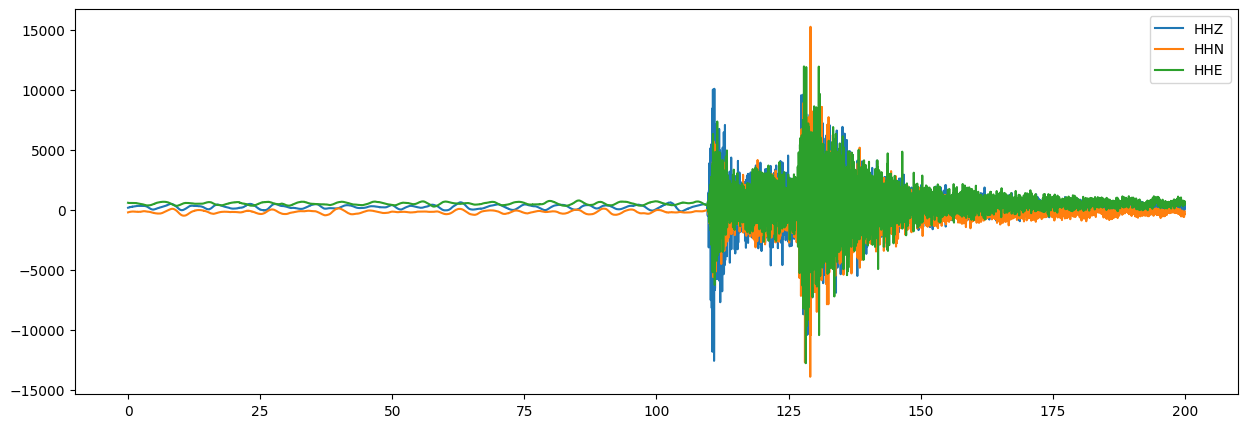

In [42]:
 ##### downloads real seismic waveform data from a station in Chile (via FDSN client), then plots the three-component waveform (Z, N, E) to prepare for annotation using SeisBench models.
# Import necessary libraries from ObsPy and matplotlib
from obspy.clients.fdsn import Client     # Access online seismic data
from obspy import UTCDateTime             # Handle time formats for seismic data
import matplotlib.pyplot as plt           # Plotting library

client = Client("GFZ")                    # Use the GFZ data provider (Germany's Geoforschungszentrum)

t = UTCDateTime("2007/01/02 05:48:50")    # Define the start time (in UTC format)

# Download 3-component waveform data (HHZ, HHN, HHE) from station PB01 in Chilean network CX
stream = client.get_waveforms(network="CX", station="PB01", location="*", channel="HH?", starttime=t-100, endtime=t+100)    # Get 200 seconds of data centered on t

# Plot the waveforms
fig = plt.figure(figsize=(15, 5))                 # Create a wide figure
ax = fig.add_subplot(111)                         # Add a single subplot

# Loop over the 3 components (Z, N, E) and plot each one
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()                         # Add legend with channel names (HHZ, HHN, HHE)

SeisBench models can generate characteristic curves, i.e., curves providing the probability of a pick at a certain time. For this, the annotate function is used. Annotate automatically transforms the trace into a compatible format for the model and merges the preditions into traces. For example, annotate will determine the correct component order and resample the trace to the required sampling rate.

In [43]:
# running model.annotate() on the seismic stream to automatically detect P and S wave arrivals, using the pretrained PhaseNet model.
annotations = model.annotate(stream)           # Applies PhaseNet to the waveform stream
print(annotations)                             # Shows the output (annotated stream)

# annotate() does
# Auto-resamples the input waveform to the model’s required sampling rate (e.g., 100 Hz)
# Reorders components if needed (to ZNE)
# Runs inference to calculate probabilities for: (P-wave arrival (.PhaseNet_P), S-wave arrival (.PhaseNet_S), No event (.PhaseNet_N))
# Returns new traces with probabilities over time

# output is 3 traces in the annotated stream, Each one represents a probability curve returned by the PhaseNet model:
# probability that there is no seismic arrival,  P-wave arrival,  S-wave arrival

# All traces span the same:
# Time range:2007-01-02 05:47:12.498392 to 05:50:27.498392 (total = 195 seconds)
# Sampling rate:100.0 Hz → 100 samples per second
# Total samples:19501 samples (≈ 195.01 seconds)

3 Trace(s) in Stream:
CX.PB01..PhaseNet_N | 2007-01-02T05:47:12.498392Z - 2007-01-02T05:50:27.498392Z | 100.0 Hz, 19501 samples
CX.PB01..PhaseNet_P | 2007-01-02T05:47:12.498392Z - 2007-01-02T05:50:27.498392Z | 100.0 Hz, 19501 samples
CX.PB01..PhaseNet_S | 2007-01-02T05:47:12.498392Z - 2007-01-02T05:50:27.498392Z | 100.0 Hz, 19501 samples


`annotate` takes additional, optional arguments that depend on the specific model and are documented in the model defintion. For example, PhaseNet is applied with a sliding window approach and therefore has a `overlap` parameter, indicating the overlap in samples between two consequtive applications of the model. Let's try out a different overlap.

In [44]:
# telling the PhaseNet model to analyze the seismic stream and generate arrival probabilities (P, S, and No arrival) — but with overlap between windows.

annotations = model.annotate(stream, overlap=2000)     # Each window overlaps the next by 2000 samples (i.e., 20 seconds if 100 Hz) to improve accuracy and smooths predictions at the edges.
print(annotations)                                     # Shows the output (annotated stream)

3 Trace(s) in Stream:
CX.PB01..PhaseNet_N | 2007-01-02T05:47:12.498392Z - 2007-01-02T05:50:27.498392Z | 100.0 Hz, 19501 samples
CX.PB01..PhaseNet_P | 2007-01-02T05:47:12.498392Z - 2007-01-02T05:50:27.498392Z | 100.0 Hz, 19501 samples
CX.PB01..PhaseNet_S | 2007-01-02T05:47:12.498392Z - 2007-01-02T05:50:27.498392Z | 100.0 Hz, 19501 samples


You might have also noticed that the annotation process took a bit longer, because PhaseNet was applied more often than with the default overlap.

Let's visualize the predictions alongside the waveforms. As we can see, PhaseNet correctly identified the P and S arrival of the main event. Note that the confidence values (the peaks of the probability curves) are high, but not quite 1. This is common for deep learning based picking models.

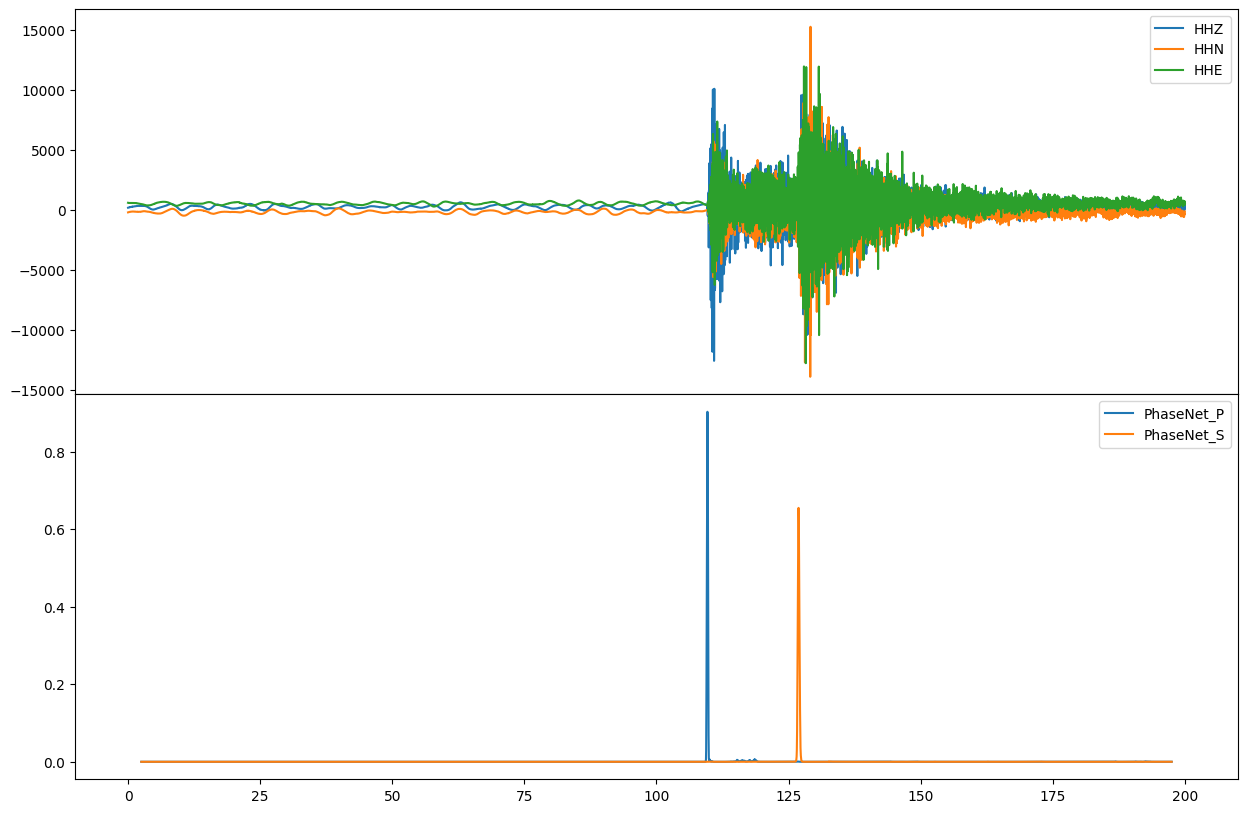

In [45]:
# visualizing how PhaseNet identifies P- and S-wave arrivals using confidence curves
fig = plt.figure(figsize=(15, 10))                # Create a large figure for clearer visualization
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0}) # Two vertically stacked plots sharing the x-axis

# Creates two subplots: one for the raw waveforms, and one for PhaseNet's predictions (P/S curves).
# Computes time offset between the original waveform and the prediction curves (annotations).
offset = annotations[0].stats.starttime - stream[0].stats.starttime

for i in range(3):      # For each of the 3 traces (Z, N, E components)
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)    # Plot waveform
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve ( Skip noise prediction and only plot P and S curves)
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)
                   # Adjusted time axis              # Probability values
axs[0].legend()
axs[1].legend()

# Plots:Top graph: raw seismic waveform (Z, N, E).
     # Bottom graph: predicted probability spikes for P and S arrivals (not noise "N").
     #  Peaks ≈ P and S arrival times.  (likelihoods of an arrival at each time.)
     # Lower or flat areas = no arrival.

In addition to the `annotate` function, SeisBench models offer the `classify` function. This function returns discrete objects, in this case, picks. Again, we can pass configuration parameters to the function. Here, we provide detection thresholds. Let's first print all outputs together.

In [50]:
# classify() = a shortcut function that outputs actual arrival picks instead of probability curves using confidence thresholds (≥0.5).
output = model.classify(stream, P_threshold=0.5, S_threshold=0.5)
print(output)
# Prints the full content of the result which holds:
# A list of picks (discrete arrival times of P and S waves) [Station Code][Arrival Time (UTC)][Phase Type]
# A list of detections with 11 entries (time windows around events).
# Time windows where full events were detected (not just single pick P/S) [Station Code] [Start Time] [End Time]
# annotate() → gives you continuous probability curves over time.
# classify() → gives you discrete P and S arrival times based on thresholds.

ClassifyOutput(creator='PhaseNet', picks=PickList with 2 entries:

CX.PB01.	2007-01-02T05:48:59.648392Z	P
CX.PB01.	2007-01-02T05:49:16.868392Z	S)


Alternatively, we can access the picks separately. The picks are a simple list that can be iterated over or access through indexing.

In [51]:
print(output.picks)          # to extracts only the picks (without the metadata).

# The output to show only the arrival picks, not the full metadata or detection windows.

PickList with 2 entries:

CX.PB01.	2007-01-02T05:48:59.648392Z	P
CX.PB01.	2007-01-02T05:49:16.868392Z	S


### Model interchangability

The standardized model API makes it easy to use a different model. Let's try out EQTransformer. For this, we use the weights trained on the STEAD dataset (Mousavi et al. 2019, Münchmeyer et al. 2022). Note that in addition to picks, EQTransformer returns detections.

In [52]:
# use the EQTransformer model to perform both arrival time picking and event detection using SeisBench on the STEAD dataset. This model can predict (P-s waves arrival time and Earthquake detection windows .
model = sbm.EQTransformer.from_pretrained("stead")
# show a description of how the model was trained, learning rate, epoch count, and credit info.
print(model.weights_docstring)

Downloading: 100%|██████████| 1.52M/1.52M [00:00<00:00, 12.6MB/s]


Model trained on STEAD for 100 epochs with a learning rate of 0.001.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench

Jannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)


3 Trace(s) in Stream:
CX.PB01..EQTransformer_Detection | 2007-01-02T05:47:14.998392Z - 2007-01-02T05:50:24.998392Z | 100.0 Hz, 19001 samples
CX.PB01..EQTransformer_P         | 2007-01-02T05:47:14.998392Z - 2007-01-02T05:50:24.998392Z | 100.0 Hz, 19001 samples
CX.PB01..EQTransformer_S         | 2007-01-02T05:47:14.998392Z - 2007-01-02T05:50:24.998392Z | 100.0 Hz, 19001 samples


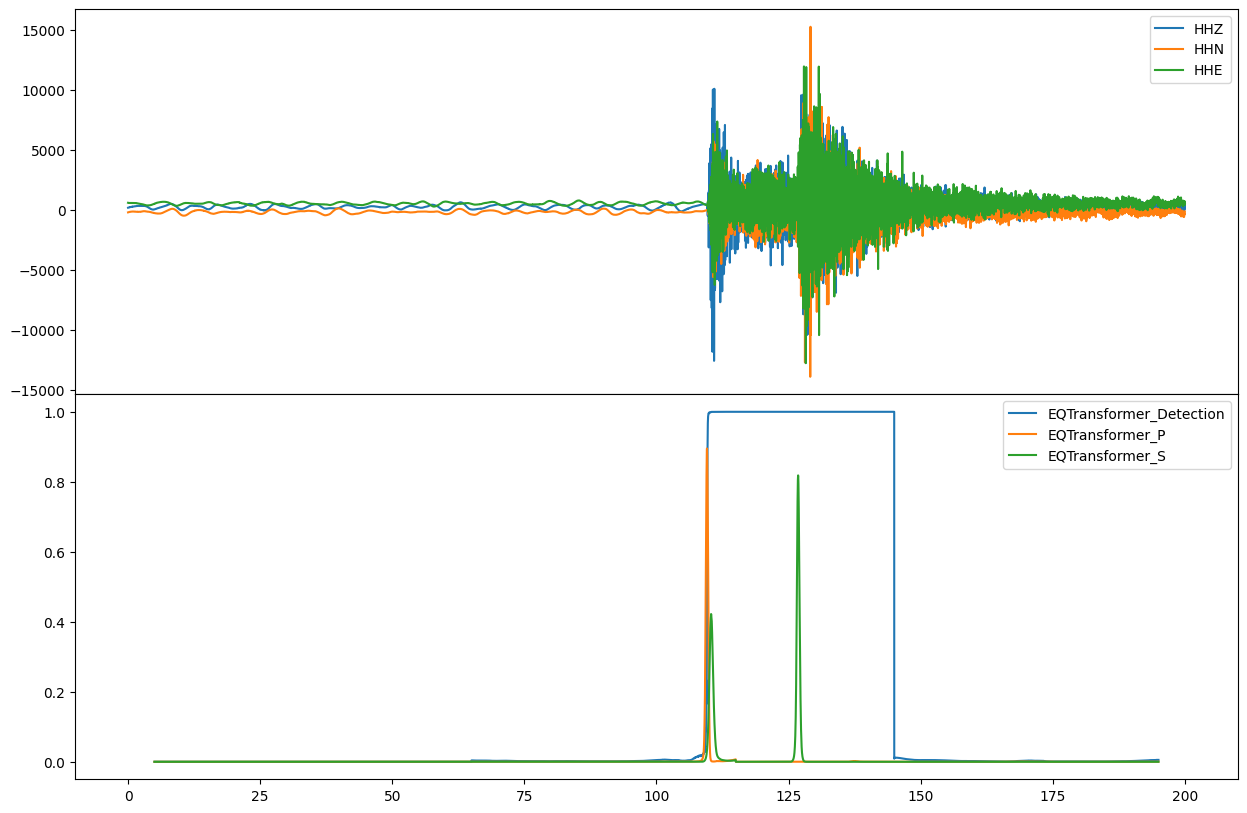

In [59]:
# use the loaded seismic waveform (stream) and runs it through the EQTransformer model.
annotations = model.annotate(stream)
print(annotations)
# The output is stored in annotations, including probability curves for:
# 1. EQTransformer_Detection: probability of earthquake happening
# 2. EQTransformer_P: P-wave probability
# 3. EQTransformer_S: S-wave probability

fig = plt.figure(figsize=(15, 10))   # Create a 15x10 inch figure
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0}) # Two subplots stacked vertically, share x-axis

offset = annotations[0].stats.starttime - stream[0].stats.starttime    # Time difference to align waveforms and predictions

for i in range(3):   # Loop through 3 channels
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)    # Plot raw waveform

    # If not the 'noise' class (N), plot the model's annotation curve
    if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()

# Output is 3 traces channels generated by the model:
# Detection: when an earthquake was likely happening
# P: likelihood of P-wave arrival at each time
# S: likelihood of S-wave arrival at each time
# 100.0 Hz: The waveform has 100 samples per second
# 19001 samples: The duration is ~190 seconds long

In [60]:
# Use the EQTransformer model to classify waveform into P and S picks and full event detection
output = model.classify(stream)
# Print the full result, including picks  of P-S waves and detection window (A time window where an event is likely occurring)
print(output)

ClassifyOutput(creator='EQTransformer', picks=PickList with 2 entries:

CX.PB01.	2007-01-02T05:48:59.548392Z	P
CX.PB01.	2007-01-02T05:49:16.808392Z	S, detections=DetectionList with 1 entries:

CX.PB01.	2007-01-02T05:48:59.618392Z	2007-01-02T05:49:34.988392Z)


As before, we can access the outputs individually, in this case we now have the `detection` attribute in addition to the `picks`.

In [61]:
# Print only the arrival picks (P and S phases)
print(output.picks)
# Print only the event detection windows (start and end times of seismic events)
print(output.detections)

PickList with 2 entries:

CX.PB01.	2007-01-02T05:48:59.548392Z	P
CX.PB01.	2007-01-02T05:49:16.808392Z	S
DetectionList with 1 entries:

CX.PB01.	2007-01-02T05:48:59.618392Z	2007-01-02T05:49:34.988392Z


### Batch processing

Processing is not limited to a single station, but can be applied to streams from different stations. SeisBench will automatically convert the traces into the correct tensors and the annotations back to streams. For more efficient processing, let's first move the model to GPU. Moving a model to GPU will automatically process the computations of `annotate` and `classify` on GPU.

**Note:** In Colab, to use GPU you need to select a GPU runtime environment.

In [63]:
# check whether a GPU (Graphics Processing Unit) is available. If yes, it sends the model to the GPU to speed up processing and if not, it prints a warning that only CPU is available.

if torch.cuda.is_available():
    model.cuda()
    print("Running on GPU")
else:
    print("NOT running on GPU")

NOT running on GPU


Now let's download the same time window as above, but for all stations in the CX network and generate the picks and detections with EQTransformer.

In [64]:
# Downloads waveform data from all stations in the CX network in the same 200s time window.
stream = client.get_waveforms(network="CX", station="*", location="*", channel="HH?", starttime=t-100, endtime=t+100)
# Apply the pretrained EQTransformer model to that full dataset.
output = model.classify(stream)
print(output.picks)  # Show discrete P and S wave picks (arrival times).
print(output.detections)  # Show detected event time windows.

PickList with 12 entries:

CX.HMBCX.	2007-01-02T05:49:05.810002Z	P
CX.HMBCX.	2007-01-02T05:49:27.680002Z	S
CX.PATCX.	2007-01-02T05:49:06.279999Z	P
...
CX.PB03.	2007-01-02T05:49:26.208392Z	S
CX.PB04.	2007-01-02T05:49:35.298392Z	S
CX.PB05.	2007-01-02T05:49:15.198392Z	P
DetectionList with 11 entries:

CX.PB03.	2007-01-02T05:48:44.998392Z	2007-01-02T05:48:55.038392Z
CX.PB04.	2007-01-02T05:48:45.378392Z	2007-01-02T05:49:00.578392Z
CX.PB01.	2007-01-02T05:48:59.618392Z	2007-01-02T05:49:34.988392Z
...
CX.PSGCX.	2007-01-02T05:49:12.550005Z	2007-01-02T05:50:04.990005Z
CX.PB05.	2007-01-02T05:49:15.308392Z	2007-01-02T05:50:04.988392Z
CX.MNMCX.	2007-01-02T05:49:15.000004Z	2007-01-02T05:50:04.990004Z


This concludes the model API tutorial. Check out the other SeisBench tutorials to get to know the other functionalities.